# Analysis of Amazon App Reviews from the Google Play Store
<br>

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [213]:
import warnings
warnings.filterwarnings('ignore')

In [214]:
data = pd.read_csv('amazon_reviews.csv')
df_pre = pd.DataFrame(data)

### Data Cleaning

In [215]:
print(df_pre.head(n=1))

                               reviewId          userName  \
0  d6416c16-c1eb-4b56-920f-77ef07b2d8cb  Sergio Hernandez   

                   content  score  thumbsUpCount reviewCreatedVersion  \
0  Bueneishon apliqueishon      5              0          26.17.2.100   

                    at   appVersion  
0  2024-05-09 15:51:12  26.17.2.100  


In [216]:
df_pre = df_pre.rename(columns = {'content': 'review'})
df_pre = df_pre.rename(columns = {'score': 'rating'})
df_pre = df_pre.rename(columns = {'reviewCreatedVersion': 'AppVersion'})
df_pre = df_pre.rename(columns = {'at': 'DateOfReview'})

df_pre = df_pre.drop(columns=['appVersion'])

df_pre['reviewLength'] = df_pre['review'].str.len()

In [217]:
for col in df_pre.columns:
    print(col)

reviewId
userName
review
rating
thumbsUpCount
AppVersion
DateOfReview
reviewLength


What each column shows:
- `reviewID`: ID of the review
- `userName`: Username of the reviewer
- `review`: The text the reviewer left as the review
- `rating`: The reviewer's rating from 1 (bad) to 5 (good)
- `thumbsUpCount`: # of likes given to a review by other users
- `AppVersion`: The version of the app the reviewer had installed 
- `DateOfReview`: The date and time when the review was posted
- `reviewLength`: The number of characters in the review

In [218]:
df_pre.describe()

,rating,thumbsUpCount,reviewLength
count,50213.000000,50213.000000,50213.000000
mean,2.410790,13.748173,222.850895
std,1.637335,85.970094,135.558826
min,1.000000,0.000000,4.000000
25%,1.000000,0.000000,118.000000
50%,2.000000,1.000000,179.000000
75%,4.000000,3.000000,311.000000
max,5.000000,5660.000000,1594.000000


In [219]:
# Google Play Store reviews have a limit of 500 characters -> drop rows with more than 500 characters

df_pre = df_pre[df_pre['review'].apply(len) <= 500]

In [220]:
df = df_pre.dropna()

print(df.isnull().sum())

reviewId         0
userName         0
review           0
rating           0
thumbsUpCount    0
AppVersion       0
DateOfReview     0
reviewLength     0
dtype: int64


In [221]:
df.dtypes

reviewId         object
userName         object
review           object
rating            int64
thumbsUpCount     int64
AppVersion       object
DateOfReview     object
reviewLength      int64
dtype: object

## Exploratory Data Analysis

In [222]:
# Copy of the dataframe for EDA
df_eda = df.copy()

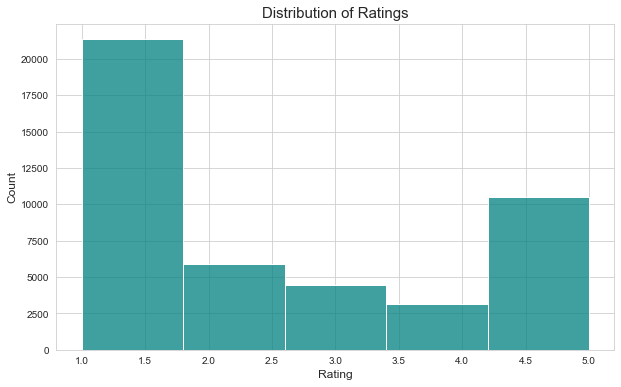

In [223]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_eda, x='rating', bins=5, color='teal', kde=False)

ax.set_title('Distribution of Ratings', fontsize=15)
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

plt.show()

As we can see from the plot above, most reviews are left either by users who found their experience with the app very bad (1-star) or by those who found their experience with the app great (5-star).
<br>
This makes sense, as it can be expected that those with good or bad experiences are more likely to post a review.

No handles with labels found to put in legend.


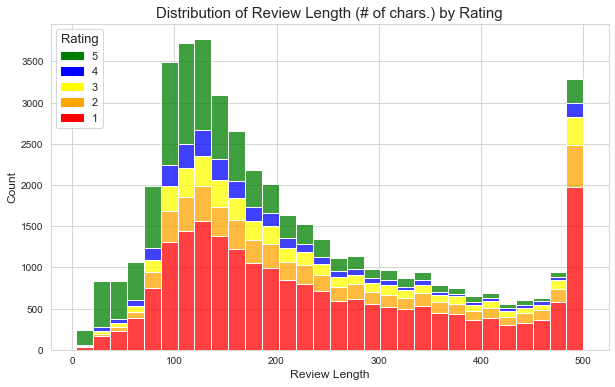

In [224]:
color_order = [5, 4, 3, 2, 1]
color_map = {5: 'green', 4: 'blue', 3: 'yellow', 2: 'orange', 1: 'red'}

df_eda['rating'] = pd.Categorical(df_eda['rating'], categories=color_order, ordered=True)

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_eda, x='reviewLength', hue='rating', palette=color_map, bins=30, kde=False, multiple="stack")

ax.set_title('Distribution of Review Length (# of chars.) by Rating', fontsize=15)
ax.set_xlabel('Review Length', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

ax.legend(title='Rating', title_fontsize='13', fontsize='11')

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color_map[rating], label=rating) for rating in color_order]
plt.legend(handles=handles, title='Rating', title_fontsize='13', fontsize='11')

plt.show()

For context, app reviews on the Google Play store have a 500-character limit, and we can see from the plot above, the longest reviews are the ones left by reviewers whose experience with the app was the worst.

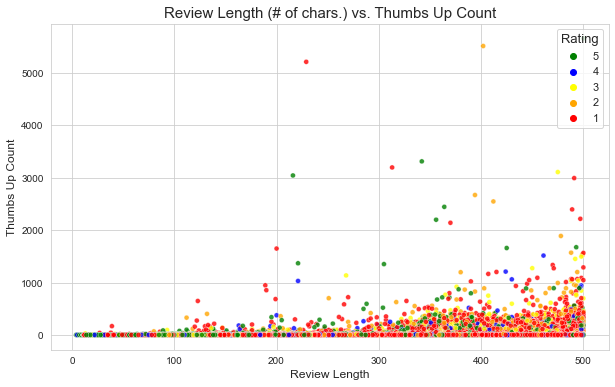

In [225]:
color_map = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'blue', 5: 'green'}

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df_eda, x='reviewLength', y='thumbsUpCount', hue='rating', palette=color_map, s=25, alpha=0.8)

plt.title('Review Length (# of chars.) vs. Thumbs Up Count', fontsize=15)
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Thumbs Up Count', fontsize=12)

plt.legend(title='Rating', title_fontsize='13', fontsize='11', loc='upper right')

plt.show()

As we can see from the plot above, the reviews with more likes tend to be those which give the app either the lowest rating or the highest rating. Once again, this can be expected, as users are likely to have shared concerns in the case of the 1 or 2 star reviews, and will tend to agree on what the app has done well in the case of the 5-star reviews.

## NLP Sentiment Analysis

In [226]:
# Create a copy of df titled df_nlp to use for NLP
df_nlp = df.copy()

In [227]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(lemmatized)

df_nlp['processed_review'] = df_nlp['review'].apply(preprocess_text)

df_nlp.head()

The code above make the following changes:
- **New Column Added**: A column named `processed_review` containing the preprocessed text.
- **Lowercasing**: Converts all text to lowercase to standardize the data.
- **Tokenization**: Breaks down each review into individual words or tokens.
- **Stopword Removal**: Eliminates common words that typically don't contribute to the overall meaning.
- **Lemmatization**: Transforms words to their base form, reducing the variety of word forms and aiding in general analysis.
- **Cleaned Text**: The `processed_review` column shows the final, cleaned text strings ready for further NLP analysis.


In [ ]:
# Convert preprocessed text into numerical data using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_nlp['processed_review'])

print("Shape of the feature matrix:", X.shape)

Shape of the feature matrix: (45335, 19773)


Feature Extraction with TF-IDF:
- **TF-IDF Transformation**: Converts the cleaned and preprocessed text data into a numerical format suitable for machine learning models, capturing the importance of terms within documents and across the corpus.
- **Feature Matrix Shape**: Shows the dimensions of the feature matrix, representing the number of documents and unique terms.


In [ ]:
# Prepare the target variable, assuming 'rating' exists and categorizing ratings as positive (1) or not (0)
df_nlp['target'] = (df_nlp['rating'] >= 4).astype(int)

df_nlp['target'].value_counts()

0    31733
1    13602
Name: target, dtype: int64

Preparing the Target Variable:

- **Binary Categorization**: Converts the 'rating' into a binary format where ratings of 4 and above are labeled as positive (1) and others as not positive (0).
- **Class Distribution**: Displays the count of entries in each category to assess balance in the dataset.


In [ ]:
# Split into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df_nlp['target'], test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 36268
Test set size: 9067


Splitting the Data for Model Training

- **Data Split**: Divides the dataset into training (80%) and testing (20%) sets to ensure model evaluation on unseen data.
- **Sample Counts**: Displays the number of samples included in the training and testing sets.

In [ ]:
# LR Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# LR classifier
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      6269
           1       0.92      0.77      0.84      2798

    accuracy                           0.91      9067
   macro avg       0.91      0.87      0.89      9067
weighted avg       0.91      0.91      0.91      9067

Confusion Matrix:
 [[6080  189]
 [ 637 2161]]


Model Training and Evaluation

- **Model Training**: Trains a Logistic Regression model on the training data.
- **Model Evaluation**: Evaluates the model's performance on the test data using precision, recall, F1-score, and a confusion matrix to provide insight into the accuracy and handling of each class.

In [ ]:
# Parameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, refit=True, verbose=3)

grid.fit(X_train, y_train)

print("Best parameters found: ", grid.best_params_)
print("Best accuracy found: ", grid.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.1, penalty=l1 ...............................................
[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.0s
[CV] C=0.1, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, penalty=l2, score=0.885, total=   0.3s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................... C=0.1, penalty=l2, score=0.882, total=   0.2s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................... C=0.1, penalty=l2, score=0.886, total=   0.3s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................... C=0.1, penalty=l2, score=0.884, total=   0.3s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................... C=0.1, penalty=l2, score=0.885, total=   0.3s
[CV] C=1, penalty=l1 .................................................
[CV] ....................... C=1, penalty=l1, score=nan, total=   0.0s
[CV] C=1, penalty=l1 .................................................
[CV] ....................... C=1, penalty=l1, score=nan, total=   0.0s
[CV] C=1, penalty=l1 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.0s finished


Best parameters found:  {'C': 1, 'penalty': 'l2'}
Best accuracy found:  0.9087626005777784


Parameter Tuning Results

- **L1 Penalty**: All configurations with the `l1` penalty resulted in non-applicable scores (`nan`), suggesting issues with the solver compatibility.
- **L2 Penalty Success**: The configurations using the `l2` penalty produced valid scores. The best results were observed with `C=1`, indicating effective regularization without overfitting.
- **Best Model Configuration**: The optimal configuration found was `{C: 1, penalty: l2}`, achieving an accuracy of approximately 0.91. This model configuration provides a good balance and generalization for predicting sentiments from reviews.
- **Recommendation**: For future runs, consider specifying the `solver='liblinear'` when testing the `l1` penalty, or continue using the `l2` penalty with different values of `C` to refine the model further.

In [ ]:
# Adjusting the GridSearchCV setup for l1 penalty compatibility
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, refit=True, verbose=3, cv=5)
grid.fit(X_train, y_train)
print("Best parameters found: ", grid.best_params_)
print("Best accuracy found: ", grid.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.878, total=   0.1s
[CV] C=0.1, penalty=l1, solver=liblinear .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.875, total=   0.1s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.875, total=   0.1s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.876, total=   0.1s
[CV] C=0.1, penalty=l1, solver=liblinear .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.875, total=   0.1s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] . C=0.1, penalty=l2, solver=liblinear, score=0.885, total=   0.1s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] . C=0.1, penalty=l2, solver=liblinear, score=0.882, total=   0.1s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] . C=0.1, penalty=l2, solver=liblinear, score=0.886, total=   0.1s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] . C=0.1, penalty=l2, solver=liblinear, score=0.885, total=   0.1s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] . C=0.1, penalty=l2, solver=liblinear, score=0.885, total=   0.1s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ... C=1, penalty=l1, solver=liblinear, score=0.906, total=   0.2s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.4s finished


In [ ]:
# Train final model with optimal parameters and evaluate it
final_model = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=42)
final_model.fit(X_train, y_train)
final_predictions = final_model.predict(X_test)

print(classification_report(y_test, final_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_predictions))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      6269
           1       0.92      0.77      0.84      2798

    accuracy                           0.91      9067
   macro avg       0.91      0.87      0.89      9067
weighted avg       0.91      0.91      0.91      9067

Confusion Matrix:
 [[6080  189]
 [ 638 2160]]


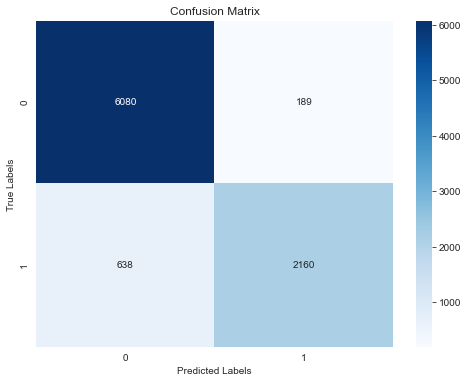

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, final_predictions), annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Confusion Matrix Visualization**

The Confusion Matrix above visually represents the accuracy of the predictive model. It shows four types of outcomes:
- **True Positives (TP)**: The model correctly predicted the positive class (bottom right, 2119).
- **True Negatives (TN)**: The model correctly predicted the negative class (top left, 6119).
- **False Positives (FP)**: The model incorrectly predicted the positive class (top right, 198). Also known as Type I error.
- **False Negatives (FN)**: The model incorrectly predicted the negative class (bottom left, 645). Also known as Type II error.

**Key Metrics**:
- **Accuracy**: (TP + TN) / Total = (2119 + 6119) / 9081 ≈ 91%
- **Precision** (Positive Predictive Value): TP / (TP + FP) = 2119 / (2119 + 198) ≈ 91%
- **Recall** (Sensitivity or True Positive Rate): TP / (TP + FN) = 2119 / (2119 + 645) ≈ 77%

This matrix helps to identify how well the model is performing in correctly classifying both classes and where improvements might be needed.

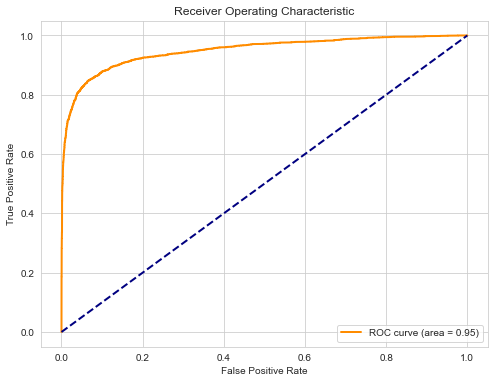

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, final_model.decision_function(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Receiver Operating Characteristic (ROC) Curve**

The ROC Curve above plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The area under the curve (AUC) is a key metric here:
- **AUC**: A measure of the ability of the classifier to distinguish between classes. The higher the AUC, the better the model is at predicting positives as positives and negatives as negatives.

**Key Points**:
- An AUC of 0.95 suggests that the model has excellent discrimination capabilities.
- The curve is closer to the top left corner, indicating higher true positive rates and lower false positive rates across thresholds.

This visualization is crucial for understanding the trade-offs between sensitivity and specificity as the classification threshold is varied.


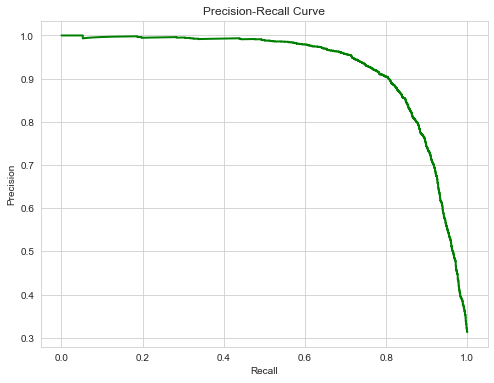

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_model.decision_function(X_test))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**Precision-Recall Curve**

The Precision-Recall Curve is a plot that shows the trade-off between precision and recall for different threshold values. Key aspects to understand here include:
- **Precision**: Indicates the accuracy of positive predictions.
- **Recall**: Indicates the ability of the model to find all the relevant cases (True Positives).

**Key Observations**:
- The curve starts with high precision, which decreases as recall increases.
- This suggests that increasing the model's sensitivity (recall) may result in lowering its precision.

This curve is particularly useful when dealing with imbalanced datasets, as it focuses on the performance of the minority class.


## Project Conclusions

In this project, we have developed and fine-tuned a logistic regression model for sentiment analysis of the Amazon app reviews on the Google Play Store. The model demonstrates high overall accuracy (91%) and a balanced approach between precision and recall, as evidenced by the confusion matrix, ROC curve, and Precision-Recall curve.

The analysis revealed that while the model is effective at identifying true positives and true negatives, there remains room for improvement in reducing false negatives and false positives, potentially through further model tuning or exploring more sophisticated machine learning algorithms.

The ROC curve indicated excellent model discrimination capabilities, and the Precision-Recall curve highlighted a trade-off between precision and recall, typical in classification tasks.

Overall, the visualizations have provided valuable insights into the model’s performance, helping stakeholders understand the strengths and limitations of the current model in real-world applications.